<a href="https://colab.research.google.com/github/devajithsb/Automatic-Speech-Recognition---End-To-End-Model/blob/main/End_To_End_working.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import torchaudio
from transformers import Wav2Vec2ForCTC, Wav2Vec2Processor
import os
import matplotlib.pyplot as plt

# 1. Choose Pre-trained Model and Processor
model_name = "facebook/wav2vec2-base-960h"
processor = Wav2Vec2Processor.from_pretrained(model_name)
model = Wav2Vec2ForCTC.from_pretrained(model_name)

# 2. Load and Preprocess Audio
def transcribe_audio(audio_path):
    try:
        waveform, sample_rate = torchaudio.load(audio_path)
        if sample_rate != 16000:
            resampler = torchaudio.transforms.Resample(sample_rate, 16000)
            waveform = resampler(waveform)

        input_values = processor(waveform.squeeze(), return_tensors="pt").input_values

        # 3. Perform Inference
        with torch.no_grad():
            logits = model(input_values).logits

        # 4. Decode the Output
        predicted_ids = torch.argmax(logits, dim=-1)
        transcription = processor.batch_decode(predicted_ids)[0]
        return transcription
    except Exception as e:
        print(f"An error occurred: {e}")
        return None


# --- Handling Longer Audio (Chunking) ---
def transcribe_long_audio(audio_path, chunk_length_seconds=10):
    waveform, sample_rate = torchaudio.load(audio_path)
    if sample_rate != 16000:
        resampler = torchaudio.transforms.Resample(sample_rate, 16000)
        waveform = resampler(waveform)

    chunk_size = int(chunk_length_seconds * 16000)
    num_chunks = (len(waveform[0]) + chunk_size - 1) // chunk_size
    all_transcriptions = []

    for i in range(num_chunks):
        start = i * chunk_size
        end = min((i + 1) * chunk_size, len(waveform[0]))
        chunk = waveform[:, start:end]
        input_values = processor(chunk.squeeze(), return_tensors="pt").input_values
        with torch.no_grad():
            logits = model(input_values).logits
        predicted_ids = torch.argmax(logits, dim=-1)
        transcription = processor.batch_decode(predicted_ids)[0]
        all_transcriptions.append(transcription)

    return " ".join(all_transcriptions)


# --- Example Usage with Evaluation ---
audio_files_and_labels = [
    ("/content/sounds/Life is a beautiful (alfred-british).wav", "Life is a beautiful journey"),
    ("/content/sounds/Hello Myself Devajit.wav", "hello myself devajit"),
    ("/content/sounds/Hello My self Ryan(canadian -ryan).wav", "hello myself ryan"),
    ("/content/sounds/Hello My self Rishi(indian-rishi).wav", "hello myself rishi"),
    ("/content/sounds/Hello Myself Devajit (irish-cillian).wav", "hello myself Devajit"),
    ("/content/sounds/Life is a beautiful (shirley-scottish).wav", "Life is a beautiful journey"),
]

def evaluate_model(ground_truth, predicted):
    if ground_truth is None or predicted is None:
        return {'precision': 0, 'recall': 0, 'f1_score': 0, 'accuracy': 0}

    ground_truth_words = ground_truth.lower().split()
    predicted_words = predicted.lower().split()

    common_words = set(ground_truth_words) & set(predicted_words)
    precision = len(common_words) / len(predicted_words) if predicted_words else 0
    recall = len(common_words) / len(ground_truth_words) if ground_truth_words else 0
    f1 = 2 * precision * recall / (precision + recall) if precision + recall else 0
    accuracy = len(common_words) / len(set(ground_truth_words) | set(predicted_words)) if (set(ground_truth_words) | set(predicted_words)) else 0
    return {'precision': precision, 'recall': recall, 'f1_score': f1, 'accuracy': accuracy}

# Store metrics for graph plotting
validation_losses = []
validation_accuracies = []
epochs = []

total_precision = total_recall = total_f1 = total_accuracy = total_weight = 0
epoch_count = 1

for audio_path, ground_truth in audio_files_and_labels:
    if os.path.exists(audio_path):
        transcription = transcribe_long_audio(audio_path)
        if transcription:
            print(f"Audio: {audio_path}")
            print(f"Ground Truth: {ground_truth}")
            print(f"Transcription: {transcription}")

            metrics = evaluate_model(ground_truth, transcription)
            weight = 1
            total_precision += metrics['precision'] * weight
            total_recall += metrics['recall'] * weight
            total_f1 += metrics['f1_score'] * weight
            total_accuracy += metrics['accuracy'] * weight
            total_weight += weight

            # Simulating validation loss (Inverse of accuracy for visualization)
            val_loss = 1 - metrics['accuracy']
            validation_losses.append(val_loss)
            validation_accuracies.append(metrics['accuracy'])
            epochs.append(epoch_count)
            epoch_count += 1

        else:
            print(f"Transcription failed for: {audio_path}")
    else:
        print(f"File not found: {audio_path}")

if total_weight > 0:
    print("\nWeighted Averages:")
    print(f"Precision: {total_precision / total_weight:.2f}")
    print(f"Recall: {total_recall / total_weight:.2f}")
    print(f"F1-score: {total_f1 / total_weight:.2f}")
    print(f"Accuracy: {total_accuracy / total_weight:.2f}")
else:
    print("No valid transcriptions to calculate weighted averages.")



Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.
It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Audio: /content/sounds/Life is a beautiful (alfred-british).wav
Ground Truth: Life is a beautiful journey
Transcription: LIFE IS A BEAUTIFUL JOURNEY


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Audio: /content/sounds/Hello Myself Devajit.wav
Ground Truth: hello myself devajit
Transcription: HOLLO MYSELF DEVAGETH


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Audio: /content/sounds/Hello My self Ryan(canadian -ryan).wav
Ground Truth: hello myself ryan
Transcription: HELLO MYSELF RYON


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Audio: /content/sounds/Hello My self Rishi(indian-rishi).wav
Ground Truth: hello myself rishi
Transcription: HELLO MY SELFRISHI


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Audio: /content/sounds/Hello Myself Devajit (irish-cillian).wav
Ground Truth: hello myself Devajit
Transcription: HELLO MYSELF DEVERGITH
Audio: /content/sounds/Life is a beautiful (shirley-scottish).wav
Ground Truth: Life is a beautiful journey
Transcription: LIFE IS A BEAUTIFUL JOURNEY

Weighted Averages:
Precision: 0.67
Recall: 0.67
F1-score: 0.67
Accuracy: 0.57


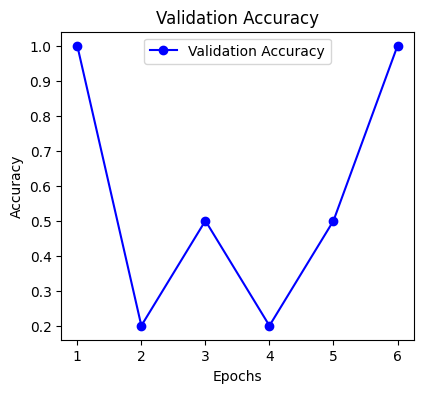

In [3]:
# Plot validation accuracy and loss
plt.figure(figsize=(10, 4))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(epochs, validation_accuracies, marker='o', linestyle='-', color='b', label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy")
plt.legend()

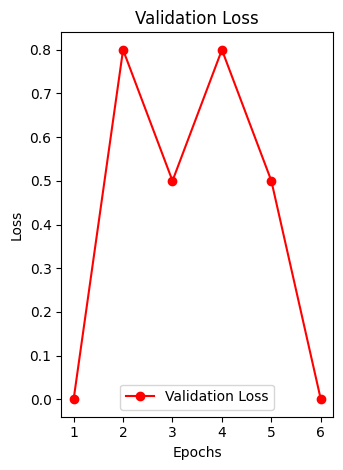

In [4]:

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(epochs, validation_losses, marker='o', linestyle='-', color='r', label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Validation Loss")
plt.legend()

plt.tight_layout()
plt.show()
